Copyright (c) 2023 Graphcore Ltd. All rights reserved.

# Training a GNN to do Fraud Detection on Graphcore IPUs using your own dataset with PyTorch Geometric

TODO: Everything in this section

TODO: Update links:

[![Run on Gradient](../../gradient-badge.svg)](https://console.paperspace.com/github/<runtime-repo>?machine=Free-IPU-POD4&container=<dockerhub-image>&file=<path-to-file-in-repo>)  [![Join our Slack Community](https://img.shields.io/badge/Slack-Join%20Graphcore's%20Community-blue?style=flat-square&logo=slack)](https://www.graphcore.ai/join-community)

>
> We aim to have our notebook app demos to be focused on what the user is trying to
> do. To help you do this correctly please read [our user personnas](https://graphcore.atlassian.net/wiki/spaces/PM/pages/3157131517/Notebook+personas#Ellie%3A-The-Data-Scientist%2C-Business-Analysis%2C-Consultant),
and when in doubt ask yourself "does that person care about this?".
> To support that the first paragraph will contain all the key information, to
> help users rapidly identify if this is the right notebook for them to go
> though, based on:
>
> - The task/business problem they are trying to solve,
> - The features that are used (Focus on big picture Deep learning features - e.g.
>  Distributed training, not I/O overlap).
>
> To achieve this, each notebook should start with the following 3 paragraphs
> (detailed in the next three comments):
>
> - a table highlighting what we are going to do
> - a very short intro (3-5 sentences)
> - clear "steps to resolution" (bullet points stating what the user will have
>    to do to tackle their problem on the IPU - these need to reflect the notebook,
>    and be as simple as possible)
> - links to additional related resources.
>

|  Domain | Tasks | Model | Datasets | Workflow |   Number of IPUs   | Execution time |
|---------|-------|-------|----------|----------|--------------|--------------|
|   GNNs   |  Fraud detection  | ? | ? | Training, evaluation | recommended: 16XX (min: 4X) | 20Xmn (X1h20mn)   |

>
>
> Start with a short introduction to the notebook. [suggested 3-5 sentences]
>
> This intro should focus on the problem you are fixing, and not on any IPU specific
> or framework specific features. The mindset is that anything that is non-standard
> is a barrier to entry, and will risk the user giving up.
>
> This short introduction should be followed by a clear bullet point summary of
> the steps of the demo. Each outcome should be of the form:
> - what the user will do (active verb) [and (optionally) how they do
>   it]. Jargon, if any, goes to the end of the bullet point.

In this demo, you will learn how to:

- Turn tabular transaction data into a PyTorch Geometric dataset
- Select a model suitable for the task of predicting fraudulent transactions
- Train the model on Graphcore IPUs
- Run validation on the trained model

This notebook assumes some familiarity with PopTorch as well as PyTorch Geometric (PyG). For additional resources please consult:
* [PopTorch Documentation](https://docs.graphcore.ai/projects/poptorch-user-guide/en/latest/index.html)
* [PopTorch Examples and Tutorials](https://docs.graphcore.ai/en/latest/examples.html#pytorch)
* [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/)
* [PopTorch Geometric Documentation](https://docs.graphcore.ai/projects/poptorch-geometric-user-guide/en/latest/index.html)

[![Join our Slack Community](https://img.shields.io/badge/Slack-Join%20Graphcore's%20Community-blue?style=flat-square&logo=slack)](https://www.graphcore.ai/join-community)

In [2]:
# Make imported python modules automatically reload when the files are changed
# needs to be before the first import.
%load_ext autoreload
%autoreload 2
# TODO: remove at the end of notebook development

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Environment setup

[![Run on Gradient](../../gradient-badge.svg)](TODO)

The best way to try this demo is on Paperspace Gradient's cloud IPUs. To use on other hardware
make sure that you have the Poplar SDK enabled with the latest PopTorch Geometric installed.

In [1]:
%pip install -q -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


To improve your experience we read some configuration related to the environment you are running the notebook in.

In [2]:
import os

number_of_ipus = int(os.getenv("NUM_AVAILABLE_IPU", 16))
pod_type = os.getenv("GRAPHCORE_POD_TYPE", "pod16")
executable_cache_dir = os.getenv("POPLAR_EXECUTABLE_CACHE_DIR", "/tmp/exe_cache/")

# TODO Remove default
dataset_directory = os.getenv("DATASETS_DIR", "~")
checkpoint_directory = os.getenv("CHECKPOINT_DIR")

## Loading tabular data into PyTorch Geometric

In [32]:
import torch

### Getting the dataset

TODO: Using https://www.kaggle.com/c/ieee-fraud-detection/data

TODO: Run a script to download and tidy data?

In [3]:
import os.path as osp
import pandas as pd

raw_dataset_path = osp.join(dataset_directory, "ieee-fraud-detection", "raw")

train_transaction_path = osp.join(raw_dataset_path, "train_transaction.csv")
train_identity_path = osp.join(raw_dataset_path, "train_identity.csv")
train_transaction_df = pd.read_csv(train_transaction_path)
train_identity_df = pd.read_csv(train_identity_path)

test_transaction_path = osp.join(raw_dataset_path, "test_transaction.csv")
test_identity_path = osp.join(raw_dataset_path, "test_identity.csv")
test_transaction_df = pd.read_csv(test_transaction_path)
test_identity_df = pd.read_csv(test_identity_path)

In [4]:
# TODO: Should train and test be combined for transductive

In [5]:
transaction_df = pd.concat([train_transaction_df, test_transaction_df], axis=0)
identity_df = pd.concat([train_identity_df, test_identity_df], axis=0)

In [6]:
transaction_df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0.0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0.0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0.0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0.0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0.0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [134]:
identity_df.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id-29,id-30,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
# TODO: Remove this
transaction_df = transaction_df.head()
transaction_df

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0.0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0.0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0.0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0.0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0.0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
# TODO: Merge dataframes

### Inspecting the dataset

TODO: Look at a few of the columns - call out important ones we will use for features and labels

TODO: Create validation / test split

NOTES: TODO: Remove

- Nodes are transaction IDs
-

In [16]:
transaction_df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0.0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0.0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0.0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0.0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0.0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Creating a PyTorch Geometric dataset

TODO: Create PyTorch Geometric dataset from above - maybe move to a separate script

In [62]:
get_cat_map = lambda vals: {val: idx for idx, val in enumerate(vals)}

In [63]:

# TODO: Use this
@dataclass
class NodeData:
    name
    node_features
    edges
    cat_map

NameError: name 'dataclass' is not defined

In [64]:
def get_edge_list(transaction_df, to_key, cat_map):
    edge_list = torch.zeros((2, len(transaction_df)), dtype=torch.long)

    for idx, transaction in transaction_df.iterrows():
        edge_list[0][idx] = idx
        edge_list[1][idx] = cat_map[transaction[to_key]]
    
    return edge_list

In [77]:
# TODO: This takes ages
# TODO: Doesn't work if all data is used

def get_nodes_and_edges(df, identifier):
    # Find number of unique categories for this node type
    unique_entries = df[identifier].drop_duplicates()
    # Create a map of category to value
    entry_map = get_cat_map(unique_entries)
    # Create node features from map
    node_features = torch.tensor(list(entry_map.values()))
    # Create edge list mapping transaction to node type
    edges = get_edge_list(df, identifier, entry_map)
    return node_features, edges


In [90]:
product_code_node_feats, product_code_edges = get_nodes_and_edges(transaction_df, "ProductCD")
product_code_node_feats, product_code_edges

(tensor([0, 1]),
 tensor([[0, 1, 2, 3, 4],
         [0, 0, 0, 0, 1]]))

In [133]:
pur_email_domain_node_feats, pur_email_domain_edges = get_nodes_and_edges(transaction_df, "P_emaildomain")
pur_email_domain_node_feats, pur_email_domain_edges

(tensor([0, 1, 2, 3]),
 tensor([[0, 1, 2, 3, 4],
         [0, 1, 2, 3, 1]]))

In [92]:
rec_email_domain_node_feats, rec_email_domain_edges = get_nodes_and_edges(transaction_df, "R_emaildomain")
rec_email_domain_node_feats, rec_email_domain_edges

(tensor([0]),
 tensor([[0, 1, 2, 3, 4],
         [0, 0, 0, 0, 0]]))

In [ ]:
# TODO: Create node features

In [82]:
import torch

from torch_geometric.data import HeteroData

data = HeteroData()

In [122]:
# TODO: Update this
data["transaction"].x = torch.arange(len(transaction_df))
# TODO: Labels
data["transaction"].y = torch.tensor(transaction_df['isFraud'], dtype=int)

data["product_code"].x = product_code_node_feats
data["transaction", "to", "product_code"].edge_index = product_code_edges

data["purchaser_email_domain"].x = pur_email_domain_node_feats
data["transaction", "to", "purchaser_email_domain"].edge_index = pur_email_domain_edges

data["recipient_email_domain"].x = rec_email_domain_node_feats
data["transaction", "to", "recipient_email_domain"].edge_index = rec_email_domain_edges

/tmp/ipykernel_41775/916473763.py:4: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  data["transaction"].y = torch.tensor(transaction_df['isFraud'], dtype=int)


In [123]:
data

HeteroData(
  transaction={
    x=[5],
    y=[5]
  },
  product_code={ x=[2] },
  purchaser_email_domain={ x=[4] },
  recipient_email_domain={ x=[1] },
  (transaction, to, product_code)={ edge_index=[2, 5] },
  (transaction, to, purchaser_email_domain)={ edge_index=[2, 5] },
  (transaction, to, recipient_email_domain)={ edge_index=[2, 5] }
)

```python
data = HeteroData(
    transaction={
        x=[],
        y=[],
        train_mask=[],
        val_mask=[],
        test_mask=[]
    },
    card_info_1={},
    card_info_2={},
    card_info_3={},
    card_info_4={},
    card_info_5={},
    card_info_6={},
    product_code={},
    purchaser_billing_addr={},
    purchaser_billing_country={},
    purchaser_email_domain={},
    recipient_email_domain={}
    (transaction, to, card_info_1)={edge_index=[2, ]},
    (transaction, to, card_info_2)={edge_index=[2, ]},
    (transaction, to, card_info_3)={edge_index=[2, ]},
    (transaction, to, card_info_4)={edge_index=[2, ]},
    (transaction, to, card_info_5)={edge_index=[2, ]},
    (transaction, to, card_info_6)={edge_index=[2, ]},
    (transaction, to, product_code)={edge_index=[2, ]},
    (transaction, to, purchaser_billing_addr)={edge_index=[2, ]},
    (transaction, to, purchaser_billing_country)={edge_index=[2, ]},
    (transaction, to, purchaser_email_domain)={edge_index=[2, ]},
    (transaction, to, recipient_email_domain)={edge_index=[2, ]},
)
```

### Visualize

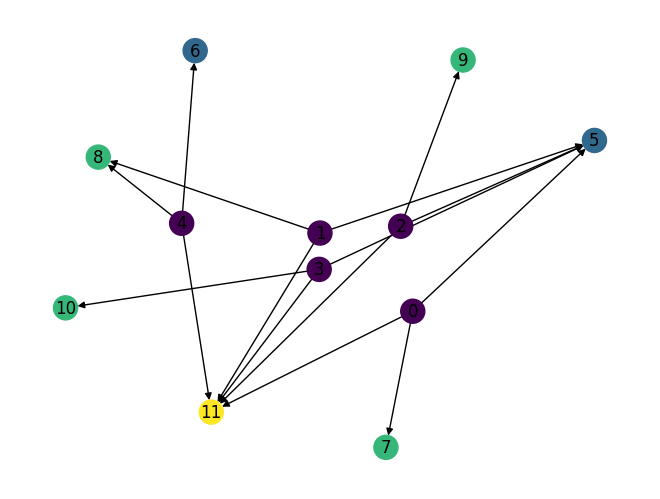

In [132]:
import networkx as nx
from matplotlib import pyplot as plt
from torch_geometric.utils import to_networkx

# Convert to homogeneous
data_homogeneous = data.to_homogeneous()
g = to_networkx(data_homogeneous)
# Use node types as colour map
colour_map = data_homogeneous.node_type

# TODO: This maybe?
## Get labels
#labels = {str(idx): val for idx, val in enumerate(data_homogeneous.y)}

# Plot the graph
nx.draw(g, node_color=colour_map, with_labels=True)
plt.show()

## Picking the right model

TODO: Describe the task

TODO: Describe different relations type - want something that can do different relations (heterogeneous graph) - RGCN could be a sensible choice
    - but requires lots of memory

TODO: Try CompGCN

## Training the model

TODO: Train the model in the normal way

## Validating our trained model

TODO: Validate the model in the normal way

## Conclusion

> The conclusion to your demo should:
>
> - summarise the main steps that were taken in the demo making clear what
>  your user got to do (similar to steps at the start but more
>  specific, you can link a specific feature/method/class to achieving a specific
>  outcome). (short paragraph: 3-6 sentences)
> - provide resources to go further: these can be links to other tutorials, to
>  documentation, to code examples in the public_examples repo, tech notes, deployments,
>  etc... (2-4 suggestions)
>
> For pointing users to notebooks in the same runtime, point the user to where the file is rather than a link. For example: please see our tutorial, `<folder_name>/<notebook_name>.ipynb`. For relative links the paperspace platform will download the file locally if the machine is running and if the machine is not running will 404. For full path links a new window is opened.